In [25]:
from cassie import CassieEnv
import functions as f
import constants as c
import loader as l 
import numpy as np
import matplotlib.pyplot as plt

In [26]:
cassie = CassieEnv({})
cassie.reset()

#register cassie as an environment
from ray.tune.registry import register_env
register_env("cassie-v0", lambda config: CassieEnv(config))


In [27]:
cassie.render_mode = "rgb_array"

In [39]:
#simulate cassie for some steps doing nothing and plot the metrics inside 
rendered_frames = []
used_quantities = []
cassie.reset()
for _ in range(300):
    obs, _, _, _,_ = cassie.step(cassie.action_space.sample()/5.0)
    rendered_frame = cassie.render()
    rendered_frames.append(rendered_frame)
    for i in range (len(obs)):
        cassie.used_quantities["ob_"+str(i)] = obs[i]
    used_quantities.append(cassie.used_quantities)

# convert list of dictionaries to dictionary of lists
used_quantities = {k: [d[k] for d in used_quantities] for k in used_quantities[0]}





(RolloutWorker pid=1442902) 2023-04-09 12:02:58,188	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=1442902) 2023-04-09 12:02:58,188	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


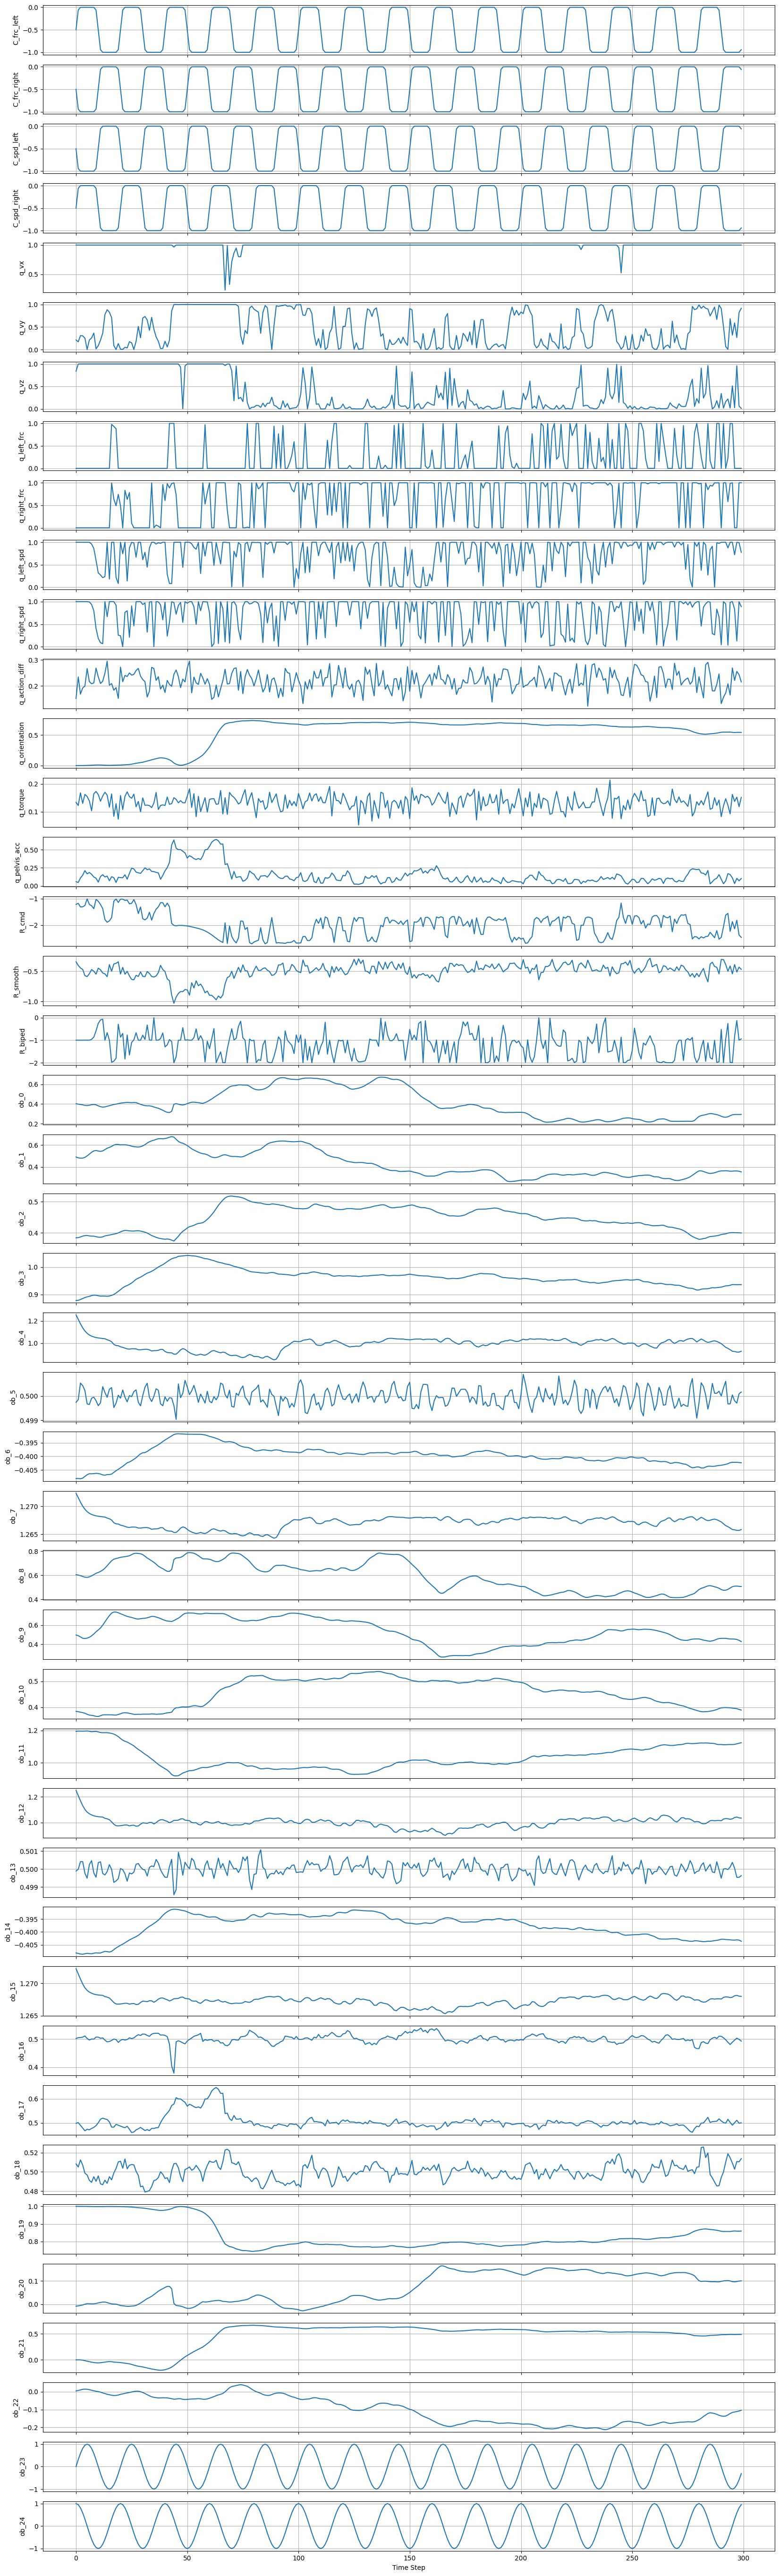

In [40]:
# plot the metrics and use the exact number on the x axis
fig, axs = plt.subplots(len(used_quantities), 1, figsize=(20, 70), sharex=True)
for i, key in enumerate(used_quantities):
    axs[i].plot(used_quantities[key])
    axs[i].set_ylabel(key)
    axs[i].grid(True)
plt.xlabel("Time Step")
plt.show()



In [55]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

def plot_cassie(rendered_frames, used_quantities,plot_keys):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    fig.subplots_adjust(bottom=0.2)

    # plot the first frame
    im = ax1.imshow(rendered_frames[0])
    ax1.axis('off')

    # plot the metrics
    lines = {}
    for key in plot_keys:
        value = used_quantities[key]
        #display the legend 

        line,= ax2.plot(value[:1], label=key)

        lines[key] = line
    ax2.set_xlabel('Frame')
    ax2.set_ylabel('Value')
    ax2.legend()
    # create the slider
    slider = widgets.IntSlider(min=0, max=len(rendered_frames)-1, step=1, value=0)

    # create an output widget to display the plot
    out = widgets.Output()

    # function to update the plot when the slider is moved
    def update_plot(frame):
        im.set_data(rendered_frames[frame])
        for key, line in lines.items():
            line.set_data(range(frame+1), used_quantities[key][:frame+1])
        ax2.relim()
        ax2.autoscale_view()
        with out:
            out.clear_output(wait=True)
            display(fig)

    slider.observe(lambda event: update_plot(event['new']), names='value')

    return widgets.VBox([out, slider])


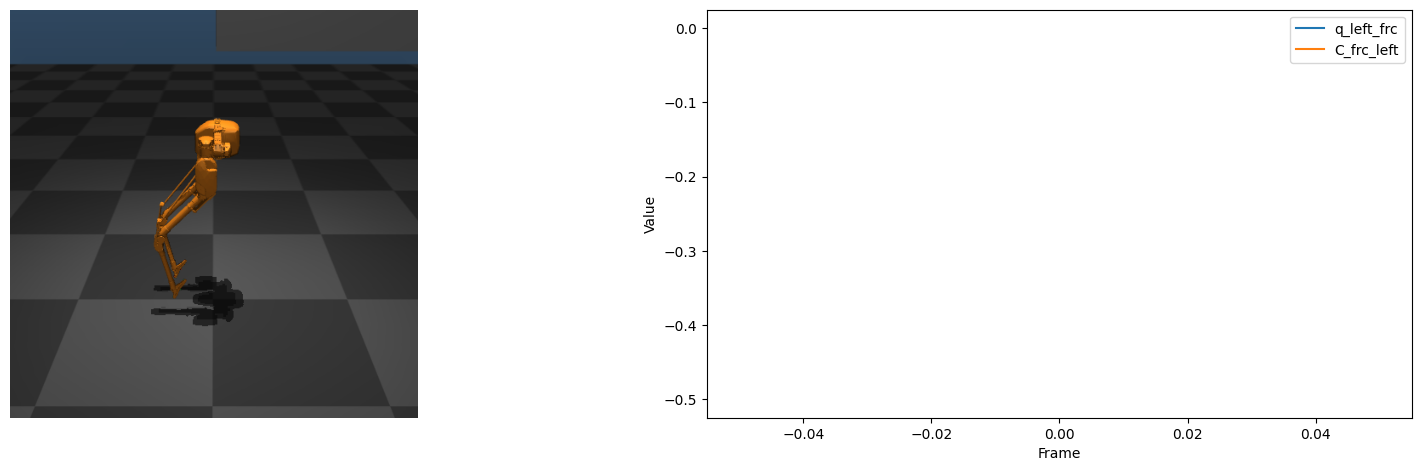

(RolloutWorker pid=1445826) 2023-04-09 12:22:15,082	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=1445826) 2023-04-09 12:22:15,082	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(raylet) [2023-04-09 12:22:24,994 E 1420396 1420396] (raylet) node_manager.cc:3040: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 3db7edebeb8cb43321c221bd524fd471ccefa56b5e1a9650dd317f5d, IP: 129.104.243.74) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 129.104.243.74`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory is

In [56]:
#plot the cassie simulation
plot_cassie(rendered_frames, used_quantities,["q_left_frc",'C_frc_left'])

In [32]:
#load the yaml file GeneralConfig.yaml as a dictionary
config = l.Loader("logs","sims").load_config("simpleConfig.yaml")

trainingConfig = config["training"]
environmentConfig = config["environment"]
frameworkConfig = config["framework"]
debuggingConfig = config["debugging"]
callbacksConfig = config["callbacks"]
resourcesConfig = config["resources"]
rolloutsConfig = config["rollouts"]
checkpointingConfig = config["checkpointing"]
evalutationConfig = config["evaluation"]


{'training': {'gamma': 0.99, 'lr': 0.001, 'train_batch_size': 50000, 'model': {'fcnet_hiddens': [256, 256], 'fcnet_activation': 'swish', 'vf_share_layers': False, 'free_log_std': True}, 'optimizer': {'type': 'adam', 'eps': '1e-08'}, 'use_critic': True, 'use_gae': True, 'lambda_': 0.95, 'kl_coeff': 0.2, 'sgd_minibatch_size': 9000, 'num_sgd_iter': 6, 'shuffle_sequences': True, 'vf_loss_coeff': 0.5, 'entropy_coeff': 0.01, 'clip_param': 0.2, 'kl_target': 0.01}, 'environment': {'env': 'cassie-v0', 'normalize_actions': True, 'clip_actions': True}, 'framework': {'framework': 'tf2', 'eager_tracing': True}, 'rollouts': {'batch_mode': 'truncate_episodes', 'observation_filter': 'MeanStdFilter'}, 'evaluation': {'evaluation_interval': 2, 'evaluation_duration': 10}, 'checkpointing': {'export_native_model_files': True}, 'debugging': {'seed': 1234}, 'callbacks': {'callbacks_class': None}, 'resources': {'num_gpus': 0}}


In [33]:

config_trad = l.Loader("logs","sims").load_config("config.yaml")
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.algorithms.ppo import PPOConfig
trainer_trad= PPOConfig().from_dict(config_trad).environment(env = 'cassie-v0').build()

2023-04-09 11:54:42,195	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation(evaluation_num_episodes=..)` has been deprecated. Use `AlgorithmConfig.evaluation(evaluation_duration=.., evaluation_duration_unit='episodes')` instead. This will raise an error in the future!


{'framework': 'torch', 'log_level': 'WARN', 'num_gpus': 0, 'num_workers': 1, 'num_envs_per_worker': 1, 'rollout_fragment_length': 'auto', 'train_batch_size': 25000, 'sgd_minibatch_size': 5000, 'num_sgd_iter': 6, 'opt_type': 'adam', 'model': {'fcnet_activation': 'swish', 'fcnet_hiddens': [256, 256], 'vf_share_layers': False, 'free_log_std': True}, 'entropy_coeff': 0.01, 'gamma': 0.99, 'lambda': 0.95, 'kl_coeff': 0.5, 'clip_param': 0.4, 'batch_mode': 'truncate_episodes', 'reuse_actors': True, 'disable_env_checking': True, 'num_gpus_per_worker': 0, 'num_cpus_per_worker': 1, 'evaluation_interval': 2, 'evaluation_num_episodes': 10, 'evaluation_config': {'env': 'cassie-v0', 'seed': 1234}}


2023-04-09 11:54:48,749	WARNING util.py:67 -- Install gputil for GPU system monitoring.


In [34]:
frameworkConfig

{'framework': 'tf2', 'eager_tracing': True}

In [35]:
from ray.rllib.algorithms.ppo import PPOConfig
trainer =PPOConfig().environment(**environmentConfig).framework(**frameworkConfig).debugging(**debuggingConfig).callbacks(**callbacksConfig).resources(**resourcesConfig).rollouts(**rolloutsConfig).checkpointing(**checkpointingConfig).evaluation(**evalutationConfig)

In [36]:
trainer.build()

(RolloutWorker pid=1440791) 2023-04-09 11:54:53,127	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=1440791) 2023-04-09 11:54:53,128	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-04-09 11:54:54,544	WARNING util.py:67 -- Install gputil for GPU system monitoring.


PPO

(RolloutWorker pid=1441245) 2023-04-09 11:55:37,764	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=1441245) 2023-04-09 11:55:37,765	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(raylet) [2023-04-09 11:56:24,964 E 1420396 1420396] (raylet) node_manager.cc:3040: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 3db7edebeb8cb43321c221bd524fd471ccefa56b5e1a9650dd317f5d, IP: 129.104.243.74) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 129.104.243.74`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory is